## LROSE WORKSHOP ERAD 2022

**Realtime CWB image. User-defined azimuth and range.**

* **This notebook pulls the CWB latest radar image from https://www.cwb.gov.tw/V8/C/W/OBS_Radar.html, and plot the scan azimuths from the planned S-Pol (Hsin-Chu) and SEA-POL (Yonaguni Isl.) radar locations.**

* **How to run?**
    1. Choose the radars (S-Pol at Hsin-Chu or SEA-POL at Yonaguni, or both)
    2. Specify the list of the scan azimuths and ranges.
    3. Check out the output figure of the scans.
    4. Repeat 2–3 to make final decision for the scan strategy.


In [2]:
#
# Extra packages to be added to anaconda3 standard packages for this notebook:
#
#  conda update --all
#  conda install cartopy netCDF4
#  conda install -c conda-forge arm_pyart
#  conda install Seaborn
#

import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import pytz
import math
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
# from pyproj import Geod
import netCDF4 as nc
# import xarray as xr
import pyart
import seaborn



## Read in radar mosaic from CF-netCDF.

In [3]:
# Read in mosaic
dataDir = os.path.join(os.environ['HOME'], 'data') 
filePathMosaic = os.path.join(dataDir, 'erad_lrose_workshop/data/mosaic_3d/20220608/20220608_120000.mdv.cf.nc')
dsMosaic = nc.Dataset(filePathMosaic)
print(dsMosaic)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: This MDV file was created by CwbRadar2Mdv.
    source: RCWF RCHL RCCG RCKT RCCK ISHI RCGI RCLY RCNT RCSL 
    title: 3D radar data mosaic from Taiwan CWB.
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(441), y0(561), z0(21)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int16 DBZ(time, z0, y0, x0)
    groups: 


In [4]:
# Compute time
uTimeSecs = dsMosaic['start_time'][0]
startTime = datetime.datetime.fromtimestamp(int(uTimeSecs))
startTimeStr = startTime.strftime('%Y/%m/%d-%H:%M:%S UTC')
print(startTimeStr)

2022/06/08-06:00:00 UTC


In [5]:
# print(dsMosaic['DBZ'])
for dim in dsMosaic.dimensions.values():
    print(dim)
for var in dsMosaic.variables.values():
    print("========================================")
    print(var)
    print("========================================")


<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'bounds', size = 2
<class 'netCDF4._netCDF4.Dimension'>: name = 'x0', size = 441
<class 'netCDF4._netCDF4.Dimension'>: name = 'y0', size = 561
<class 'netCDF4._netCDF4.Dimension'>: name = 'z0', size = 21
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: Data time
    units: seconds since 1970-01-01T00:00:00Z
    axis: T
    bounds: time_bounds
    comment: 2022-06-08T12:00:00Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 start_time(time)
    long_name: start_time
    units: seconds since 1970-01-01T00:00:00Z
    comment: 2022-06-08T12:00:00Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 stop_time(time)
    long_name: stop_time
    uni

In [20]:
# create 3D dbz array with nans for missing vals

dsDbz = dsMosaic['DBZ']
dbz3D = np.array(dsDbz)
fillValue = dsDbz._FillValue

print("fillValue: ", fillValue)

if (len(dbz3D.shape) == 4):
    dbz3D = dbz3D[0]


fillValue:  -32768


In [22]:
# Compute mosaic grid limits
(nZMosaic, nYMosaic, nXMosaic) = dbz3D.shape
lon = np.array(dsMosaic['x0'])
lat = np.array(dsMosaic['y0'])
ht = np.array(dsMosaic['z0'])
dLonMosaic = lon[1] - lon[0]
dLatMosaic = lat[1] - lat[0]
minLonMosaic = lon[0] - dLonMosaic / 2.0
maxLonMosaic = lon[-1] + dLonMosaic / 2.0
minLatMosaic = lat[0] - dLatMosaic / 2.0
maxLatMosaic = lat[-1] + dLatMosaic / 2.0
minHtMosaic = ht[0]
maxHtMosaic = ht[-1]
print("minLonMosaic, maxLonMosaic: ", minLonMosaic, maxLonMosaic)
print("minLatMosaic, maxLatMosaic: ", minLatMosaic, maxLatMosaic)
print("minHt, maxHt: ", minHtMosaic, maxHtMosaic)
print("ht: ", ht)
del lon, lat, ht

minLonMosaic, maxLonMosaic:  117.9937515258789 123.5062484741211
minLatMosaic, maxLatMosaic:  19.993749618530273 27.006250381469727
minHt, maxHt:  1.0 17.0
ht:  [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17. ]


In [23]:
# Slice to get 2D plane
dbz2D = dbz3D[0:1][0]
#print("dbzPlane0.shape: ", dbzPlane0.shape)
#dbz2D = dbzPlane0.reshape(dbzPlane0.shape[1],dbzPlane0.shape[2])
#print(dbz2D.shape)
#print(dbz2D[dbz2D != fillValue])
#dbz2D = dbzPlane0[0]
print(dbz2D.shape)
print(dbz2D[dbz2D != fillValue])

(561, 441)
[23.000004 19.000004 37.000004 ... 26.500004 28.500004 22.000004]


In [24]:
# Create map for plotting lat/lon grids
def new_map(fig):
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    ## Set extent the same as radar mosaic
    ax.set_extent([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'weight': 'bold'}
    
    return ax

In [25]:
# Compute column-max reflectivity
dbzPlaneMax = np.amax(dbz3D, (0))
dbzPlaneMax[dbzPlaneMax == fillValue] = np.nan
print(dbzPlaneMax.shape)
print(dbzPlaneMax[dbzPlaneMax != np.nan])
print(np.min(dbzPlaneMax[dbzPlaneMax != np.nan]))
print(np.max(dbzPlaneMax))

(561, 441)
[      nan       nan       nan ... 23.000004 24.000004 25.000004]
nan
nan


Text(0.5, 1.0, 'Radar mosaic DBZ: 2022/06/08-06:00:00 UTC')

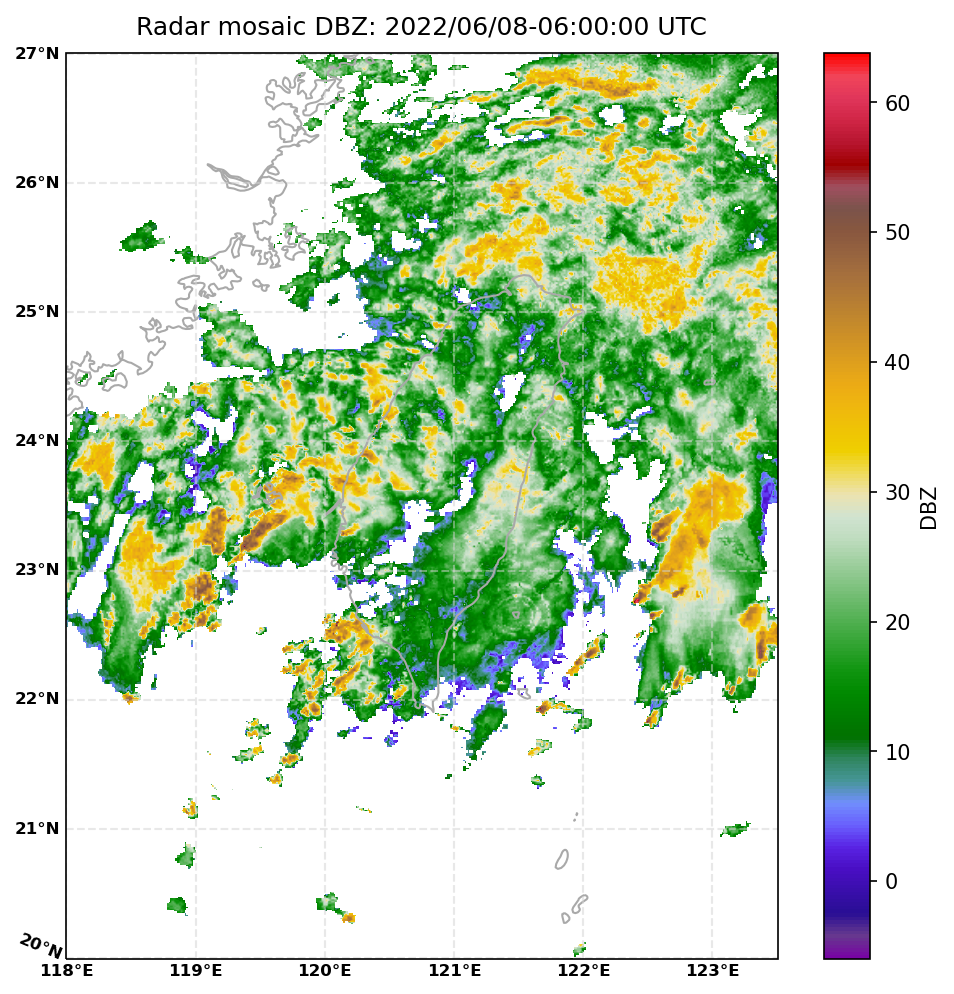

In [26]:
# Plot column-max reflectivity
fig1 = plt.figure(figsize=(8, 8), dpi=150)
ax1 = new_map(fig1)
plt.imshow(dbzPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic))
ax1.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical")
plt.title("Radar mosaic DBZ: " + startTimeStr)

In [27]:
# Compute W-E DBZ vertical section
nYHalfMosaic = int(nYMosaic/2)
dbzVertWE = dbz3D[:, nYHalfMosaic:(nYHalfMosaic+1), :]
print(dbzVertWE.shape)
dbzVertWE = dbzVertWE.reshape(dbzVertWE.shape[0], dbzVertWE.shape[2])
print(dbzVertWE.shape)
dbzVertWE[dbzVertWE == fillValue] = np.nan
dbzWEMax = np.amax(dbz3D, (1))
dbzWEMax[dbzWEMax == fillValue] = np.nan

(21, 1, 441)
(21, 441)


Text(0.5, 1.0, 'Vert slice mid W-E DBZ: 2022/06/08-06:00:00 UTC')

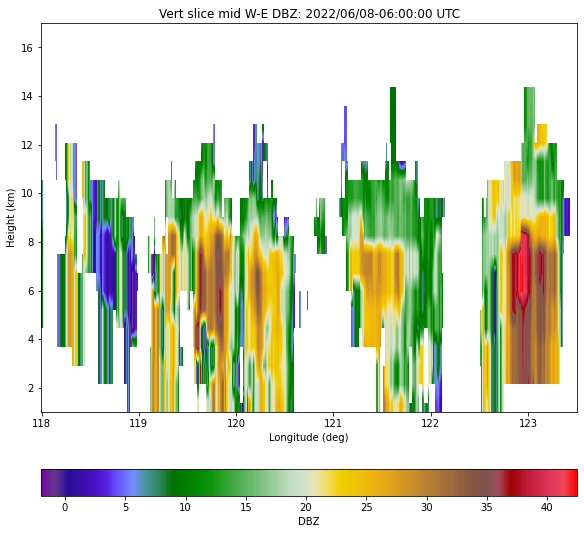

In [28]:
# Plot W-E DBZ vertical section
fig2 = plt.figure(num=2, figsize=[8, 8], layout='constrained')
ax2 = fig2.add_subplot(1, 1, 1, xlim = (minLonMosaic, maxLonMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertWE,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonMosaic, maxLonMosaic, minHtMosaic, maxHtMosaic))
ax2.set_aspect(0.25)
ax2.set_xlabel('Longitude (deg)')
ax2.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E DBZ: " + startTimeStr)

In [29]:
# Compute DBZ N-S vertical section
nXHalfMosaic = int(nXMosaic/2)
dbzVertNS = dbz3D[:, :, nXHalfMosaic:(nXHalfMosaic+1)]
dbzVertNS = dbzVertNS.reshape(dbzVertNS.shape[0], dbzVertNS.shape[1])
dbzVertNS[dbzVertNS == fillValue] = np.nan
print(dbzVertNS.shape)
dbzNSMax = np.amax(dbz3D, (2))
dbzNSMax[dbzNSMax == fillValue] = np.nan

(21, 561)


(21, 561)


Text(0.5, 1.0, 'Vert slice mid NS DBZ: 2022/06/08-06:00:00 UTC')

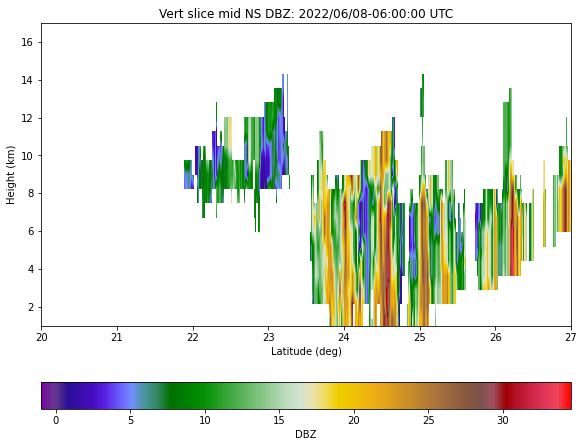

In [30]:
# Plot DBZ N-S vertical section
print(dbzVertNS.shape)
fig3 = plt.figure(num=3, figsize=[8, 8], layout='constrained')
ax3 = fig3.add_subplot(1, 1, 1, xlim = (minLatMosaic, maxLatMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertNS,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatMosaic, maxLatMosaic, minHtMosaic, maxHtMosaic))
ax3.set_aspect(0.25)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid NS DBZ: " + startTimeStr)

In [32]:
# Read in temperature profile from GFS model

dataDir = os.path.join(os.environ['HOME'], 'data') 
filePathModel = os.path.join(dataDir, 'erad_lrose_workshop/data/gfs/20220608/20220608_120000.mdv.cf.nc')
dsModel = nc.Dataset(filePathModel)
print(dsModel)
dstemp = dsModel['TMP']
temp3D = np.array(dstemp)
fillValuetemp = dstemp._FillValue
if (len(temp3D.shape) == 4):
    temp3D = temp3D[0]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    source: Grib2
    title: GFS
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(400), y0(400), z0(29)
    variables(dimensions): float64 time(time), float64 forecast_reference_time(time), float64 forecast_period(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), float32 TMP(time, z0, y0, x0), float32 RH(time, z0, y0, x0), float32 UGRD(time, z0, y0, x0), float32 VGRD(time, z0, y0, x0), float32 HGT(time, z0, y0, x0), float32 Pressure(time, z0, y0, x0)
    groups: 


In [33]:
# Compute Model grid limits
(nZModel, nYModel, nXModel) = temp3D.shape
lon = np.array(dsModel['x0'])
lat = np.array(dsModel['y0'])
ht = np.array(dsModel['z0'])
dLonModel = lon[1] - lon[0]
dLatModel = lat[1] - lat[0]
minLonModel = lon[0] - dLonModel / 2.0
maxLonModel = lon[-1] + dLonModel / 2.0
minLatModel = lat[0] - dLatModel / 2.0
maxLatModel = lat[-1] + dLatModel / 2.0
minHtModel = ht[0]
maxHtModel = ht[-1]
print("nZModel, nYModel, nXModel", nZModel, nYModel, nXModel)
print("minLonModel, maxLonModel: ", minLonModel, maxLonModel)
print("minLatModel, maxLatModel: ", minLatModel, maxLatModel)
print("minHt, maxHt: ", minHtModel, maxHtModel)
print("ht: ", ht)
del lon, lat, ht

nZModel, nYModel, nXModel 29 400 400
minLonModel, maxLonModel:  99.95000076293945 139.94999313354492
minLatModel, maxLatModel:  4.950000047683716 44.95000147819519
minHt, maxHt:  0.0 18.0
ht:  [ 0.    0.25  0.5   0.75  1.    1.5   2.    2.5   3.    3.5   4.    4.5
  5.    5.5   6.    6.5   7.    7.5   8.    9.   10.   11.   12.   13.
 14.   15.   16.   17.   18.  ]


In [34]:
# Compute Temp N-S vertical section
nXHalfModel = int(nXModel/2)
tempVertNS = temp3D[:, :, nXHalfModel:(nXHalfModel+1)]
tempVertNS = tempVertNS.reshape(tempVertNS.shape[0], tempVertNS.shape[1])
tempVertNS[tempVertNS == fillValue] = np.nan
print(tempVertNS.shape)
tempNSMax = np.amax(temp3D, (2))
tempNSMax[tempNSMax == fillValue] = np.nan

# Compute Temp W-E vertical section
nYHalfModel = int(nYModel/2)
tempVertWE = temp3D[:, nYHalfModel:(nYHalfModel+1), :]
print(tempVertWE.shape)
tempVertWE = tempVertWE.reshape(tempVertWE.shape[0], tempVertWE.shape[2])
tempVertWE[tempVertWE == fillValue] = np.nan
tempWEMax = np.amax(temp3D, (1))
tempWEMax[tempWEMax == fillValue] = np.nan
print(tempVertWE.shape)

(29, 400)
(29, 1, 400)
(29, 400)


Text(0.5, 1.0, 'Vert slice mid W-E temp: 2022/06/08-06:00:00 UTC')

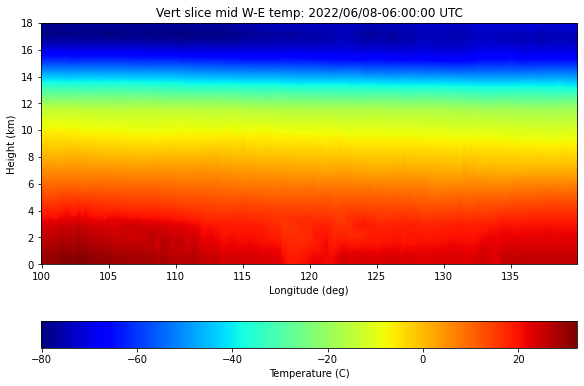

In [36]:
# Plot W-E temp vertical section
fig4 = plt.figure(num=4, figsize=[8, 8], layout='constrained')
ax4 = fig4.add_subplot(1, 1, 1, xlim = (minLonModel, maxLonModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertWE,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonModel, maxLonModel, minHtModel, maxHtModel))
ax4.set_aspect(1.0)
ax4.set_xlabel('Longitude (deg)')
ax4.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E temp: " + startTimeStr)

Text(0.5, 1.0, 'Vert slice mid N-S temp: 2022/06/08-06:00:00 UTC')

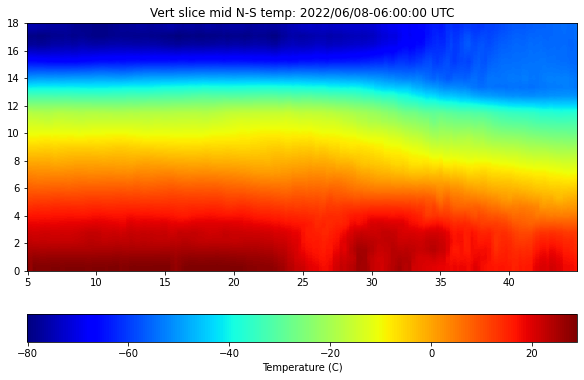

In [37]:
# Plot N-S temp vertical section
fig5 = plt.figure(num=5, figsize=[8, 8], layout='constrained')
ax5 = fig5.add_subplot(1, 1, 1, xlim = (minLatModel, maxLatModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertNS,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatModel, maxLatModel, minHtModel, maxHtModel))
ax3.set_aspect(0.25)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid N-S temp: " + startTimeStr)

#### Functions for time retrieving:

#### Retrieve the latest radar image form CWB and generate one test plot:
* Choose between two different CWB map types ('L'arge area / 'C'oncentrate to Taiwan) \
and w/wo topography (wo:1 / w:2).
* The URL for of the latest radar image will be printed for checking.

#### Function generating maps and azimuth rings:

***
#### <font color='red'>! Don't worry about the cells above !</font> unless you want to make some further edits.
***

### <font color='forestgreen'>User specifications from here:<font color='darkorange'>
### <font color='darkorange'>1. Choose the radars:</font>
**Keep the radar you want to make the figure and comment the other.**